In [ ]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

class EA:
    def __init__(self, problem, parentSelection, survivorSelection):
        self.problem = problem
        self.parentSelection = parentSelection
        self.survivorSelection = survivorSelection

    def fitness(self, individual):
        return self.problem.Fitness(individual)

    def crosover(self, individual1, individual2):
        newIndividual = self.problem.Crossover(individual1, individual2)
        return newIndividual

    def mutation(self, individual):
        individual = self.problem.Mutation(individual)
        return individual

    def genFitness(self):
        return [self.fitness(i) for i in self.generation]


In [ ]:
import numpy as np
import random


class Selection:
    def __init__(self, problem):
        self.selected = []
        # self.population = population
        # self.selection_size = selection_size
        self.problem = problem

    def FitnessProportionalSelection(self, population, selection_size):
        sum_fitness = sum([self.problem.Fitness(sensor) for sensor in population])
        selection_prob = [self.problem.Fitness(sensor) / sum_fitness for sensor in population]
        self.selected = []
        for i in range(selection_size):
            # print(np.random.choice(len(population), 1, p = selection_prob))
            self.selected.append(population[np.random.choice(len(population), 1, p=selection_prob).tolist()[0]])
        return self.selected

    def RankBasedSelection(self, population, selection_size):
        self.selected = []
        worst_sorted_fitness = sorted(population, key=lambda agent: self.problem.Fitness(agent))
        ranks = np.arange(1, len(worst_sorted_fitness) + 1, 1)
        selection_prob = [r / sum(ranks) for r in ranks]
        for i in range(selection_size):
            self.selected.append(worst_sorted_fitness[np.random.choice(len(worst_sorted_fitness), p=selection_prob)])
        return self.selected

    def BinaryTournamentSelection(self, population, selection_size):
        self.selected = []
        for i in range(selection_size):
            binary = random.choices(population, k=2)
            sorted_binary = sorted(binary, key=lambda agent: self.problem.Fitness(agent), reverse=True)
            self.selected.append(sorted_binary[0])
        return self.selected

    def TruncationSelection(self, population, selection_size):
        self.selected = []
        truncation_threshold = 0.0
        trunc = sorted(population, key=lambda agent: self.problem.Fitness(agent), reverse=True)[
                :max(int(len(population) * truncation_threshold), 1)]
        for i in range(selection_size):
            self.selected.append(trunc[random.randint(0, len(trunc) - 1)])
        return self.selected

    def RandomSelection(self, population, selection_size):
        return random.choices(population, k = selection_size)


In [ ]:
import random
from math import floor, sqrt, exp, log

def intersect(a,b,c,d):
    if a==c and b==d:
        return False,-1,-1,-1
    if a==d and b==c:
        return False,-1,-1,-1

    # stuff for line 1
    a1 = b[1]-a[1]
    b1 = a[0]-b[0]
    c1 = a1*a[0] + b1*a[1]

    # stuff for line 2
    a2 = d[1]-c[1]
    b2 = c[0]-d[0]
    c2 = a2*c[0] + b2*c[1]

    determinant = a1*b2 - a2*b1

    if (determinant == 0):
        return False,-1,-1,-1
    else:
        x = (b2*c1 - b1*c2)/determinant
        y = (a1*c2 - a2*c1)/determinant
        return True,determinant,x,y

class IndividualSensorGrid:
    def __init__(self, walls, positions, sensors):
        self.positions = positions
        self.walls = walls
        self.sensors = sensors
        self.fitness = -1

    def getFitness(self):
        if self.fitness == -1:
            self.computeFitness()
        return self.fitness

    def checkWall(self, position, sensor, wall):
        l1 =(sensor, position)
        ds = []
        for i in range(4,len(wall)):
            hit, d, x, y = intersect(sensor,position,wall[i],wall[(i+1)%len(wall)])
            if hit:
                ds.append((d,x,y))
        if len(ds)==2:
            return True, min(ds,key = lambda x: x[0]), max(ds, key = lambda x: x[0])
        else:
            return False, -1,-1

    def pointToPointDist(self, start, end):
        return sqrt(sum((i-j)**2 for i,j in zip(start, end)))

    def signalStrengthDist(self, position, sensor, hits):
        initialStrength = 10
        airFade = 1/20
        wallFade = 1/2

        totalDistWall = 0
        for i in hits:
            totalDistWall += self.pointToPointDist(i[0], i[1])

        totalDistAir = abs(self.pointToPointDist(position, sensor) - totalDistWall)

        return initialStrength * (log(totalDistWall))*wallFade * log(totalDistAir)*airFade

    def calculateSignalStrength(self, position, sensor):
        hits = []
        for wall in self.walls:
            hit, enterPoint, exitPoint = self.checkWall(position, sensor, wall)
            if hit:
                hits.append((enterPoint, exitPoint))
        return self.signalStrengthDist(position, sensor, hits)

    def computeFitness(self):
        summ = 0
        for i in range(len(self.positions)):
            currentMax = 0
            for j in range(len(self.sensors)):
                strength = self.calculateSignalStrength(self.positions[i], self.sensors[j])
                currentMax = max(currentMax, strength)
            summ += currentMax
        self.fitness = summ

class SensorEA:
    def __init__(self, walls, positions, numsensors):
        self.walls = walls
        self.positions = positions
        self.numsensors = numsensors
        self.maxx = max(i[0] for i in positions)
        self.maxy = max(i[1] for i in positions)
        self.minx = min(i[0] for i in positions)
        self.miny = min(i[1] for i in positions)

    def filterPositions(self):
        positions = []
        for i in self.positions:
            if not self.checkCollisionWalls(i):
                positions.append(i)
        self.positions = positions

    def checkCollisionSingleObj(self, point, obj):
        signs = []
        for i in range(len(obj)):
            v1 = obj[i]
            v2 = obj[(i+1)%len(obj)]
            a = tuple(j-i for i,j in zip(v1,v2))
            b = tuple(j-i for i,j in zip(v1, point))
            cp = a[0] * b[1] - b[0] * a[1]
            sign = cp > 0
            signs.append(sign)
        return len(set(signs)) == 1

    def checkCollisionWalls(self, point):
        for wall in self.walls:
            if self.checkCollisionSingleObj(point, wall):
                return True
        return False

    def randomYPlacement(self):
        return random.random() * (self.maxy - self.miny) + self.miny

    def randomXPlacement(self):
        if random.random()<0.5:
            return self.maxx
        else:
            return  self.minx

    def initRandomSensor(self):
        return (self.randomXPlacement(), self.randomYPlacement())

    def initValidRandomSensor(self):
        sensor = self.initRandomSensor()
        while self.checkCollisionWalls(sensor):
            sensor = self.initRandomSensor()
        return sensor

    def initializePopulation(self, population):
        gen = []
        for i in range(population):
            sensors = []
            for i in range(self.numsensors):
                sensor = self.initValidRandomSensor()
                sensors.append(sensor)
            gen.append(IndividualSensorGrid(self.walls, self.positions, sensors))

        return gen

    def Fitness(self, individual):
        return individual.getFitness()

    def Crossover(self, individual1, individual2):
        d = len(individual1.sensors[0])
        linearize1 = [coordinates[1] for coordinates in individual1.sensors]
        linearize2 = [coordinates[1] for coordinates in individual2.sensors]
        crossover = int(random.random() * (len(linearize1) + 1))
        new = linearize1[:crossover] + linearize2[crossover:]
        sensors = []
        for i in range(0, len(new)):
            sensors.append([individual1.sensors[i][0],new[i]])
        return IndividualSensorGrid(self.walls, self.positions, sensors)

    def Mutation(self, individual):
        sensors = individual.sensors
        ind = int(random.random() * len(sensors))
        sensors[ind][1] = self.randomYPlacement()
        while self.checkCollisionWalls(sensors[ind]):
            sensors[ind][1] = self.randomYPlacement()
        return IndividualSensorGrid(self.walls, self.positions, sensors)

[(3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (5, 21), (5, 22), (5, 23), (5, 24), (5, 25), (5, 26), (5, 27), (5, 28), (5, 29), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (6, 16), (6, 17), (6, 18), (6, 19), (6, 20), (6, 21), (6, 22), (6, 23), (6, 24), (6, 25), (6, 26), (6, 27), (6, 28), 

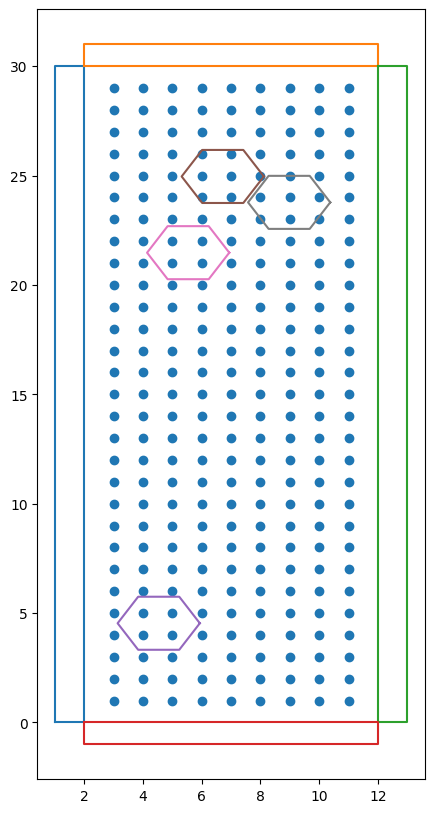

In [ ]:
import random
from matplotlib import pyplot as plt
import math


wall1 = [(1,0), (2,0), (2,30), (1,30)]
wall2 = [(2,30), (12,30), (12,31), (2,31)]
wall3 = [(12,30), (12,0), (13,0), (13,30)]
wall4 = [(2,0),(2,-1),(12,-1),(12,0)]

walls = [wall1, wall2, wall3, wall4]

def polCreate(r, s):
    points = []
    centerx = random.random() * 6 + 4
    centery = random.random() * 21 + 4
    for i in range(s):
        angle = i * math.pi * 2 / s
        x = r * math.cos(angle)
        y = r * math.sin(angle)
        p = (x + centerx, y + centery)
        points.append(p)
    return points

for i in range(4):
    w=polCreate(1.4, 6)

    walls.append(w)

positions = []
step = 1

for i in range(3, 12, step):
    for j in range(1,30, step):
        positions.append((i,j))

plt.figure(figsize=(5,10))
for i in walls:
    lst = i + i[0:1]
    plt.plot(*zip(*lst))
print(positions)
print(*zip(*positions))
plt.scatter(*zip(*positions))

plt.show()

In [ ]:
problem = SensorEA(walls, positions, 3)
problem.filterPositions()
print(problem.positions)
selobj = Selection(problem)
eaobject = EA(problem,selobj.FitnessProportionalSelection, selobj.BinaryTournamentSelection )

[(3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (4, 1), (4, 2), (4, 3), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (5, 1), (5, 2), (5, 3), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (5, 23), (5, 24), (5, 25), (5, 26), (5, 27), (5, 28), (5, 29), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (6, 16), (6, 17), (6, 18), (6, 19), (6, 20), (6, 23), (6, 27), (6, 28), (6, 29), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (7, 10), (7, 1

In [ ]:
population = 30
numGen = 800
mutRate = 0.5
numOffSpring = 10
iterations = 1

iteration: 1
generation: 1 fitness: [1669.7260852067084, 1640.1278886695436, 1693.8604879653672, 1640.1278886695436, 1676.161589038607, 1723.0240881462435, 1723.0240881462435, 1671.7250220992078, 1725.8485949611775, 1525.2583529532135, 1877.4610153766776, 1627.6902908717557, 1669.7260852067084, 1850.7706800508117, 1850.7706800508117, 1617.0536451943656, 1877.4610153766776, 1534.6668022841461, 1543.3059880631765, 1683.7704739177987, 1675.31622407227, 1692.6924325368443, 1675.31622407227, 1656.6925994440821, 1843.8037257393898, 1671.7250220992078, 1693.8604879653672, 1824.9321663229757, 1843.8037257393898, 1627.6902908717557]
generation: 2 fitness: [1877.4610153766776, 1543.3059880631765, 1669.7260852067084, 1675.31622407227, 1877.4610153766776, 1877.4610153766776, 1656.6925994440821, 1671.7250220992078, 1736.5050042208345, 1683.7704739177987, 1675.31622407227, 1843.8037257393898, 1850.7706800508117, 1877.4610153766776, 1889.5730735679745, 1677.4854052980297, 1693.8604879653672, 1850.770

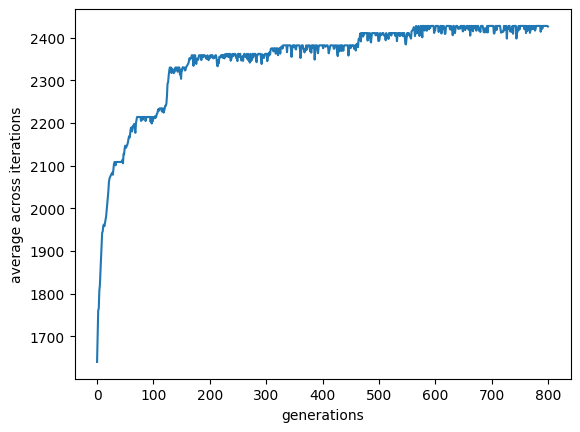

In [ ]:
iterWiseFitnessAvgs = []
iterWiseFitnessMaxs = []
for i in range(iterations):

    BSF = None
    BSFVal = - 1

    genWiseFitness = []
    eaobject.generation = eaobject.problem.initializePopulation(population)
    genWiseFitness.append(eaobject.genFitness())
    print("iteration:",i+1)
    for gen in range(numGen):
        parents = eaobject.parentSelection(eaobject.generation, numOffSpring * 2)
        # print(len(parents))
        for i in range(0, numOffSpring * 2, 2):
            newIndividual = eaobject.crosover(parents[i], parents[i + 1])
            if random.random() < mutRate:
                newIndividual = eaobject.mutation(newIndividual)
            eaobject.generation.append(newIndividual)
        eaobject.generation = eaobject.survivorSelection(eaobject.generation, population)

        gf = eaobject.genFitness()
        maxGF = max(gf)
        if maxGF > BSFVal:
            BSFVal = maxGF
            BSF = eaobject.generation[gf.index(maxGF)]
        genWiseFitness.append(gf)
        print("generation:",gen+1,"fitness:",gf)
    genWiseFitness = np.array(genWiseFitness)
    genWiseFitnessAvgs = genWiseFitness.mean(axis=1)
    genWiseFitnessMaxs = np.maximum.accumulate(genWiseFitness.max(axis=1), axis=0)
    print("Average:",genWiseFitnessAvgs,"Max:",genWiseFitnessMaxs)
    iterWiseFitnessAvgs.append(genWiseFitnessAvgs)
    iterWiseFitnessMaxs.append(genWiseFitnessMaxs)
iterWiseFitnessAvgs = np.array(iterWiseFitnessAvgs)
iterWiseFitnessMaxs = np.array(iterWiseFitnessMaxs)
iterWiseAvgs = iterWiseFitnessAvgs.mean(axis=0)
iterWiseMaxs = np.maximum.accumulate(iterWiseFitnessMaxs, axis=1).max(axis=0)
plt.plot(range(numGen + 1), iterWiseAvgs)
plt.xlabel("generations")
plt.ylabel("average across iterations")
plt.show()

finalsensors = BSF.sensors

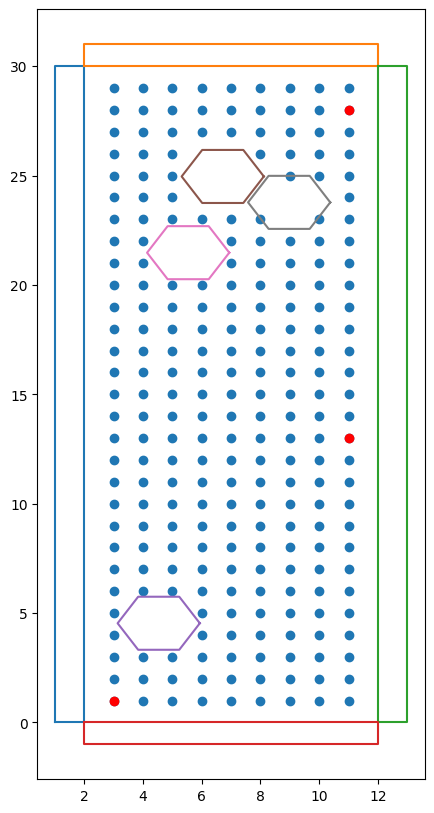

In [ ]:
plt.figure(figsize=(5,10))
for i in walls:
    lst = i + i[0:1]
    plt.plot(*zip(*lst))

plt.scatter(*zip(*problem.positions))
plt.scatter(*zip(*finalsensors), c="red")

plt.show()